# Integrated Gradients

Analysis of feature importance using the lstm model

## Setup & Imports

In [ ]:
import torch
from captum.attr import IntegratedGradients
import numpy as np
import matplotlib.pyplot as plt
from models.lstm.lstm_utils.species_predictor import SpeciesPredictor

In [12]:
ckpt_path = "../../../data/lstm_training/results/species_model-epoch=06-val_loss=0.8285.ckpt"

n_features = 72
n_classes = 7
class_weights = None
device = "cuda" if torch.cuda.is_available() else "cpu"

model = SpeciesPredictor.load_from_checkpoint(
    ckpt_path,
    n_features=n_features,
    n_classes=n_classes,
    class_weights=class_weights,
    strict=False
)
model.to(device)
model.eval()

print("Model loaded and ready for Integrated Gradients.")

Model loaded and ready for Integrated Gradients.


c:\Users\evely\OneDrive - bwedu\Documents\Uni\7. Semester\AWP2\tree_classification\.tree_venv\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.weight']


Predicted class index: 3
Integrated Gradients computed.
Attributions shape: torch.Size([1, 20, 72])


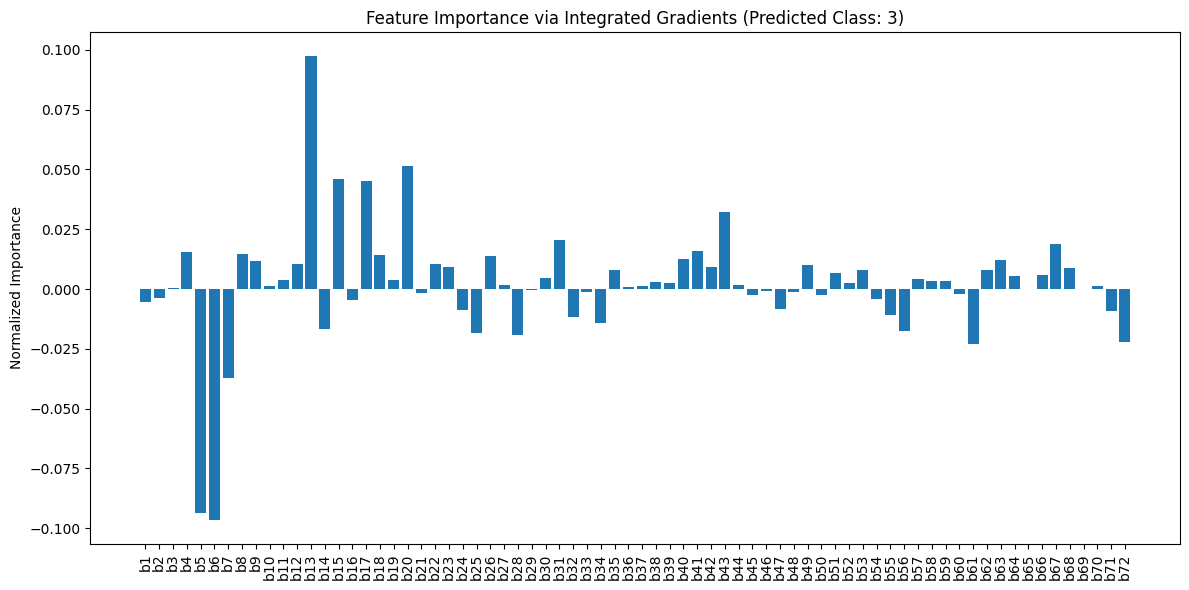

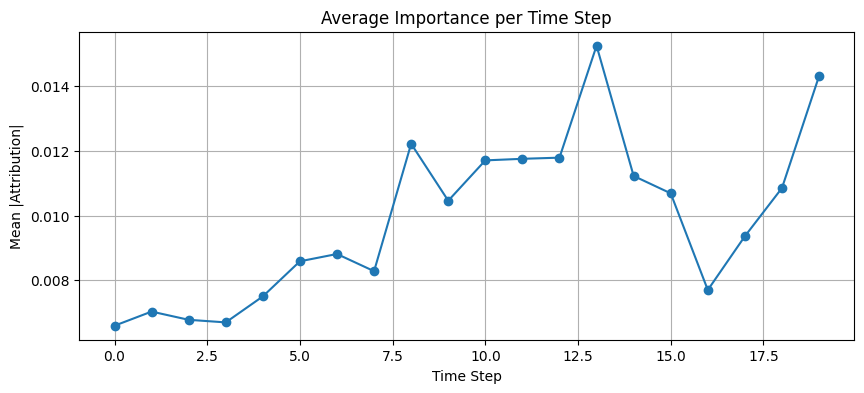

In [13]:
# Replace this with a real sequence from your dataset later!
sequence_length = 20  # e.g., 20 time steps
sample_sequence = torch.randn(1, sequence_length, n_features).to(device)

# Forward pass to get prediction
with torch.no_grad():
    output = model(sample_sequence)
pred_class = torch.argmax(output, dim=1).item()
print(f"Predicted class index: {pred_class}")


ig = IntegratedGradients(model)

attributions, delta = ig.attribute(
    sample_sequence,
    target=pred_class,
    return_convergence_delta=True
)

print("Integrated Gradients computed.")
print(f"Attributions shape: {attributions.shape}")


# Average over time dimension to get feature-level importance
feature_importance = attributions.squeeze(0).mean(dim=0).detach().cpu().numpy()

# Normalize for better visualization
feature_importance = feature_importance / np.sum(np.abs(feature_importance))

# If you have names of spectral bands:
feature_names = [f"b{i}" for i in range(1, n_features + 1)]

# Plot feature importances-
plt.figure(figsize=(12, 6))
plt.bar(range(n_features), feature_importance)
plt.xticks(range(n_features), feature_names, rotation=90)
plt.ylabel("Normalized Importance")
plt.title(f"Feature Importance via Integrated Gradients (Predicted Class: {pred_class})")
plt.tight_layout()
plt.show()

# Get time-step importance
timestep_importance = attributions.squeeze(0).abs().mean(dim=1).detach().cpu().numpy()

plt.figure(figsize=(10, 4))
plt.plot(range(sequence_length), timestep_importance, marker='o')
plt.title("Average Importance per Time Step")
plt.xlabel("Time Step")
plt.ylabel("Mean |Attribution|")
plt.grid(True)
plt.show()

In [17]:
# --- Integrated Gradients Feature Importance for LSTM ---

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients

from models.lstm.lstm_utils.species_predictor import SpeciesPredictor
from models.lstm.lstm_utils.data_loader import CSVDataLoader
from models.lstm.lstm_utils.utility_functions import df_to_sequences
from sklearn.preprocessing import LabelEncoder, StandardScaler

# ----------------------------
# 1️⃣ Load trained model
# ----------------------------
ckpt_path = "../../../data/lstm_training/results/species_model-epoch=06-val_loss=0.8285.ckpt"
device = "cuda" if torch.cuda.is_available() else "cpu"

n_features = 72
n_classes = 7
class_weights = None

model = SpeciesPredictor.load_from_checkpoint(
    ckpt_path,
    n_features=n_features,
    n_classes=n_classes,
    class_weights=class_weights,
    strict=False
)
model.to(device)
model.eval()
print("✅ LSTM model loaded successfully.")

# ----------------------------
# 2️⃣ Load dataset (processed version)
# ----------------------------
data_path = "../../../data/processed/testset.csv"  # or trainset.csv / valset.csv
df = pd.read_csv(data_path)
print(f"Loaded dataset with {len(df)} rows.")

# ----------------------------
# 3️⃣ Basic preprocessing to match training
# ----------------------------
label_column = "species"
exclude_columns = ["time", "id", "disturbance_year", "is_disturbed", "date_diff", "year", "doy"]

# Encode labels
le = LabelEncoder()
df[label_column] = le.fit_transform(df[label_column])

# Identify feature columns
feature_columns = [c for c in df.columns if c not in exclude_columns + [label_column]]

# Scale features
scaler = StandardScaler()
df[feature_columns] = scaler.fit_transform(df[feature_columns])

# ----------------------------
# 4️⃣ Extract one sequence by ID
# ----------------------------
tree_id = df["id"].unique()[0]  # pick first tree ID, or specify manually
print(f"Using tree ID: {tree_id}")

tree_df = df[df["id"] == tree_id].sort_values("time")

sequence = tree_df[feature_columns].values
sequence_tensor = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0).to(device)

print(f"Sequence shape: {sequence_tensor.shape}")

# ----------------------------
# 5️⃣ Run prediction
# ----------------------------
with torch.no_grad():
    output = model(sequence_tensor)
pred_class = torch.argmax(output, dim=1).item()
pred_species = le.inverse_transform([pred_class])[0]
print(f"Predicted species: {pred_species} (class index {pred_class})")

# ----------------------------
# 6️⃣ Integrated Gradients
# ----------------------------
ig = IntegratedGradients(model)
attributions, delta = ig.attribute(sequence_tensor, target=pred_class, return_convergence_delta=True)

print("✅ Integrated Gradients computed.")
print(f"Attributions shape: {attributions.shape}")

# ----------------------------
# 7️⃣ Aggregate & visualize
# ----------------------------
# Average over time → feature importance
feature_importance = attributions.squeeze(0).mean(dim=0).detach().cpu().numpy()
feature_importance = feature_importance / np.sum(np.abs(feature_importance))

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_columns)), feature_importance)
plt.xticks(range(len(feature_columns)), feature_columns, rotation=90)
plt.ylabel("Normalized Importance")
plt.title(f"Feature Importance via Integrated Gradients\n(Tree ID: {tree_id}, Predicted Species: {pred_species})")
plt.tight_layout()
plt.show()

# Time-step importance
timestep_importance = attributions.squeeze(0).abs().mean(dim=1).detach().cpu().numpy()

plt.figure(figsize=(10, 4))
plt.plot(range(len(timestep_importance)), timestep_importance, marker='o')
plt.title(f"Average Importance per Time Step\n(Tree ID: {tree_id}, Predicted Species: {pred_species})")
plt.xlabel("Time Step (sorted by date)")
plt.ylabel("Mean |Attribution|")
plt.grid(True)
plt.show()


c:\Users\evely\OneDrive - bwedu\Documents\Uni\7. Semester\AWP2\tree_classification\.tree_venv\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.weight']


✅ LSTM model loaded successfully.
Loaded dataset with 30800 rows.
Using tree ID: 53
Sequence shape: torch.Size([1, 154, 31])


RuntimeError: input.size(-1) must be equal to input_size. Expected 72, got 31

In [19]:
print(len(feature_columns))
print("Sample features:", feature_columns)


31
Sample features: ['b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b8a', 'b11', 'b12', 'ndvi', 'gndvi', 'wdvi', 'tndvi', 'savi', 'ipvi', 'mcari', 'reip', 'masvi2', 'dvi', 'ndmi', 'nbr', 'ndwi', 'mtci', 'rendvi', 'month_num', 'season', 'biweek_of_year', 'biweek_sin', 'biweek_cos', 'is_growing_season']
